# Crown-free Processes

In [1]:
import dot_magic
import daglib

The BIT-decomposition scheme only work on so-called "crown-free" processes. In this notebook we show how to detect and eliminate crown-minors in control graphs, while preserving the semantics of processes.

## Crown detection

In [2]:
def dag_view(dag):
    return dot_magic.show_dot(dag.to_dot())
daglib.DAG.view = dag_view

In [3]:
def select(s):
    for e in s:
        return e

In [4]:
def make_crown_2_2():
    dag = daglib.DAG()
    daglib.DAGVertex.NODE_ID = int(0)

    a = dag.add_vertex()
    b = dag.add_vertex()
    
    c = dag.add_vertex()
    d = dag.add_vertex()

    dag.add_edge(a, c)
    dag.add_edge(a, d)
    dag.add_edge(b, c)
    dag.add_edge(b, d)

    return dag

In [5]:
crown_2_2 = make_crown_2_2()

In [6]:
def make_crown_maison_2_2():
    dag = daglib.DAG()
    daglib.DAGVertex.NODE_ID = int(0)

    m = dag.add_vertex()
    
    a = dag.add_vertex()
    b = dag.add_vertex()
    
    c = dag.add_vertex()
    d = dag.add_vertex()

    dag.add_edge(m, a)
    dag.add_edge(m, b)
    dag.add_edge(a, c)
    dag.add_edge(a, d)
    dag.add_edge(b, c)
    dag.add_edge(b, d)

    return dag

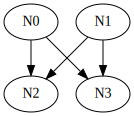

In [7]:
crown_2_2.view()

In [8]:
crown_maison_2_2 = make_crown_maison_2_2()
crown_maison_2_2.view()

In [9]:
def make_crown_2_stairs():
    dag = daglib.DAG()
    daglib.DAGVertex.NODE_ID = int(0)
    
    a = dag.add_vertex()
    b = dag.add_vertex()
    c = dag.add_vertex()
    
    d = dag.add_vertex()
    e = dag.add_vertex()
    f = dag.add_vertex()
    
    g = dag.add_vertex()
    h = dag.add_vertex()
    i = dag.add_vertex()
    
    dag.add_edge(a, d)
    dag.add_edge(a, i)
    dag.add_edge(b, g)
    dag.add_edge(b, e)
    dag.add_edge(b, f)
    dag.add_edge(c, h)
    dag.add_edge(c, f)
    
    dag.add_edge(d, g)
    dag.add_edge(d, h)
    dag.add_edge(e, i)

    return dag

In [10]:
crown_2_stairs = make_crown_2_stairs()
crown_2_stairs.view()

In [11]:
def make_crown(n):
    dag = daglib.DAG()
    daglib.DAGVertex.NODE_ID = int(0)
    
    tops = [dag.add_vertex() for _ in range(n)]
    bots = [dag.add_vertex() for _ in range(n)]

    for i in range(1, n):
        dag.add_edge(tops[i], bots[i])
        dag.add_edge(tops[i], bots[i-1])
    
    dag.add_edge(tops[0], bots[0])
    dag.add_edge(tops[0], bots[n-1])
    
    return dag

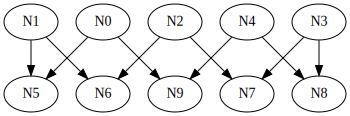

In [12]:
crown_5_5 = make_crown(5)
crown_5_5.view()

In [13]:
def find_not_visited(nodes, visited):
    for node in nodes:
        if node not in visited:
            return node
        
    return None

In [14]:
def find_turn(vertex, direction, visited):
    
    found = False
    
    while not found:
        visited.add(vertex)

        if direction == 'down':
            if not vertex.nexts:
                #raise ValueError("Cannot go down!")
                return (None, vertex.nexts, visited)
            else:
                candidate = find_not_visited(vertex.nexts, visited)
                if candidate is None:
                    # there should be a crown in the visited
                    return (None, vertex.nexts, visited)
                else:
                    vertex = candidate
        else:
            if not vertex.preds:
                #raise ValueError("Cannot go up!")
                return (None, vertex.preds, visited) # error ?
            else:
                candidate = find_not_visited(vertex.preds, visited)
                if candidate is None:
                    # there should be a crown in the visited
                    return (None, vertex.preds, visited)
                else:
                    vertex = candidate
                
        found = (direction == 'down' and len(vertex.preds) >= 2) \
                or (direction == 'up' and len(vertex.nexts) >= 2)
        
    print("found turn=", vertex)
    return (vertex, None, visited)

In [15]:
find_turn(select(crown_2_2.vertices), 'down', set())

found turn= DAGVertex(id=2)


(DAGVertex(id=2), None, {DAGVertex(id=0)})

In [16]:
def detect_crown(from_top):
    visited = set()
    wcrown = []
    last_top = None
    
    #import pdb ; pdb.set_trace()
    
    turn, _, nvisited = find_turn(from_top, "down", visited)
    if turn is None:
        return wcrown
    
    visited = set()
    last_bot = turn
    
    node = turn
    direction = "up"
        
    while True:
        turn, ends, nvisited = find_turn(node, direction, visited)
        if turn is None:
            if ends:
                for i in range(len(wcrown)-2, -1, -1):
                    if wcrown[i][0] in ends:
                        wcrown.append((node, wcrown[i][0]))
                        return wcrown[i:]
            print("pas de ends ?")
            return wcrown
        visited = nvisited
            
        if direction == "down":
            last_bot = turn
            if last_top is not None:
                wcrown.append((last_top, last_bot))
                last_top = None
        else:
            last_top = turn
            if last_bot is not None:
                wcrown.append((last_bot, turn))
                last_bot = None
            
        direction = "up" if direction == "down" else "down"
        node = turn
    


In [17]:
def detect_one_crown(dag):
    from_top = select({ top for top in dag.vertices if not top.preds})
    print("top node=", from_top)
    return detect_crown(from_top)

In [18]:
detect_one_crown(crown_2_2)

top node= DAGVertex(id=0)
found turn= DAGVertex(id=2)
found turn= DAGVertex(id=0)
found turn= DAGVertex(id=3)
found turn= DAGVertex(id=1)


[(DAGVertex(id=2), DAGVertex(id=0)),
 (DAGVertex(id=0), DAGVertex(id=3)),
 (DAGVertex(id=3), DAGVertex(id=1)),
 (DAGVertex(id=1), DAGVertex(id=2))]

In [19]:
detect_one_crown(crown_maison_2_2)

top node= DAGVertex(id=0)
found turn= DAGVertex(id=3)
found turn= DAGVertex(id=1)
found turn= DAGVertex(id=4)
found turn= DAGVertex(id=2)


[(DAGVertex(id=3), DAGVertex(id=1)),
 (DAGVertex(id=1), DAGVertex(id=4)),
 (DAGVertex(id=4), DAGVertex(id=2)),
 (DAGVertex(id=2), DAGVertex(id=3))]

In [20]:
detect_one_crown(crown_2_stairs)

top node= DAGVertex(id=0)
found turn= DAGVertex(id=8)
found turn= DAGVertex(id=0)
found turn= DAGVertex(id=6)
found turn= DAGVertex(id=1)


[(DAGVertex(id=8), DAGVertex(id=0)),
 (DAGVertex(id=0), DAGVertex(id=6)),
 (DAGVertex(id=6), DAGVertex(id=1)),
 (DAGVertex(id=1), DAGVertex(id=8))]

In [21]:
detect_one_crown(crown_5_5)

top node= DAGVertex(id=0)
found turn= DAGVertex(id=9)
found turn= DAGVertex(id=0)
found turn= DAGVertex(id=5)
found turn= DAGVertex(id=1)
found turn= DAGVertex(id=6)
found turn= DAGVertex(id=2)
found turn= DAGVertex(id=7)
found turn= DAGVertex(id=3)
found turn= DAGVertex(id=8)
found turn= DAGVertex(id=4)


[(DAGVertex(id=9), DAGVertex(id=0)),
 (DAGVertex(id=0), DAGVertex(id=5)),
 (DAGVertex(id=5), DAGVertex(id=1)),
 (DAGVertex(id=1), DAGVertex(id=6)),
 (DAGVertex(id=6), DAGVertex(id=2)),
 (DAGVertex(id=2), DAGVertex(id=7)),
 (DAGVertex(id=7), DAGVertex(id=3)),
 (DAGVertex(id=3), DAGVertex(id=8)),
 (DAGVertex(id=8), DAGVertex(id=4)),
 (DAGVertex(id=4), DAGVertex(id=9))]